# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Содержание проекта
___

[Подготовка](#3_preparing)<br>
[1. Импорт данных и изучение общей информации](#3_1.)<br>
[2. Подготовка данных](#3_2.)<br>
[2.1. Предобработка данных](#3_2.1)<br>
[2.2. Расчет дополнительных метрик для каждого пользователя](#3_2.2)<br>
[3. Анализ данных](#3_3.)<br>
[4. Проверка гипотез](#3_4.)<br>
[4.1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается](#3_4.1)<br>
[4.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#3_4.2)<br>
[5. Общий вывод](#3_5.)<br>

<a id='3_preparing'></a>
# Подготовка

## Импорт библиотек

### Основные библиотеки

In [195]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import re

### Библиотеки для работы с графиками

In [196]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as ps
import plotly.io as pio

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

### Настройки библиотек

In [197]:
# Меняем форматтер для отобраения вещественных чисел, чтобы приятно смотреть было на числа
pd.options.display.float_format = lambda x: f"{x:5,.6g}".replace(",", " ")

In [198]:
#Настраиваем графики
PLOTLY_TEMPLATE = pio.templates["ggplot2"]
PLOTLY_TEMPLATE["layout"].update(margin=dict(l=15,r=15,t=70,b=15,autoexpand=True), height=500, width=1000)
pio.templates.default = PLOTLY_TEMPLATE
pio.renderers.default = "png"
pio.kaleido.scope.default_scale = 1.5

mpl.style.use("ggplot")
mpl.rcParams["figure.figsize"] = 16,8
mpl.rcParams["figure.dpi"] = 96
mpl.rcParams["savefig.dpi"] = 300

sns.set(); sns.set(rc={'figure.figsize':(11.7,8.27)})

<a id='3_1.'></a>
# 1. Импорт данных и изучение общей информации


___

## Описание данных

### Тариф «Смарт»

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   
   
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей


### Тариф «Ультра»

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   
   
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

___

## Импорт таблицы "users" (информация о пользователях)

###  Описание данных

* ***user_id*** — уникальный идентификатор пользователя
* ***first_name*** — имя пользователя
* ***last_name*** — фамилия пользователя
* ***age*** — возраст пользователя (годы)
* ***reg_date*** — дата подключения тарифа (день, месяц, год)
* ***churn_date*** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* ***city*** — город проживания пользователя
* ***tariff*** — название тарифного плана

In [199]:
users = pd.read_csv("./datasets/users.csv")
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [200]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


## Импорт таблицы "calls" (информация о звонках)

###  Описание данных

* ***id*** — уникальный номер звонка
* ***call_date*** — дата звонка
* ***duration*** — длительность звонка в минутах
* ***user_id*** — идентификатор пользователя, сделавшего звонок

In [201]:
calls = pd.read_csv("./datasets/calls.csv")
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.8,1000
4,1000_4,2018-12-15,5.18,1000


In [202]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


## Импорт таблицы "messages" (информация о сообщениях)

###  Описание данных

* ***id*** — уникальный номер сообщения
* ***message_date*** — дата сообщения
* ***user_id*** — идентификатор пользователя, отправившего сообщение

In [203]:
message = pd.read_csv("./datasets/messages.csv")
message.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [204]:
message.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


## Импорт таблицы "internet" (информация об интернет-сессиях)

###  Описание данных

* ***id*** — уникальный номер сессии
* ***mb_used*** — объём потраченного за сессию интернет-трафика (в мегабайтах)
* ***session_date*** — дата интернет-сессии
* ***user_id*** — идентификатор пользователя

In [205]:
internet = pd.read_csv("./datasets/internet.csv", index_col=0)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1 052.81,2018-09-07,1000
2,1000_2,1 197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [206]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


## Импорт таблицы "tariffs" (информация о тарифах)

###  Описание данных

* ***tariff_name*** — название тарифа
* ***rub_monthly_fee*** — ежемесячная абонентская плата в рублях
* ***minutes_included*** — количество минут разговора в месяц, включённых в абонентскую плату
* ***messages_included*** — количество сообщений в месяц, включённых в абонентскую плату
* ***mb_per_month_included*** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* ***rub_per_minute*** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* ***rub_per_message*** — стоимость отправки сообщения сверх тарифного пакета
* ***rub_per_gb*** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [207]:
tariffs = pd.read_csv("./datasets/tariffs.csv")
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [208]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


<a id="3_2."></a>
# 2. Подготовка данных

<a id="3_2.1"></a>
## 2.1. Предобработка данных

* [*users*](#users_preparation)
* [*calls*](#calls_preparation)
* [*message*](#message_preparation)
* [*internet*](#internet_preparation)
* [*tariffs*](#tariffs_preparation)

<a id="users_preparation"></a>
### *users (пользователи)* : 

Осмотрим данные:

In [209]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пропуски есть только в колонках, связанных с датой прекращения использования тарифа, что говорит о том, что пользователь продолжает пользоваться. Поэтому пропуски оставляем, поскольку они играют важную роль и сами по себе несут необходимую информацию.

Приведем строковые данные к одному регистру:

In [210]:
users["city"] = users["city"].str.lower().str.replace("ё", "е")
users["first_name"] = users["first_name"].str.lower()
users["last_name"] = users["last_name"].str.lower()
users["tariff"] = users["tariff"].str.lower()

Выполним преобразование типов:

In [211]:
users["reg_date"] = pd.to_datetime(users["reg_date"])
users["churn_date"] = pd.to_datetime(users["churn_date"])
users["tariff"] = users["tariff"].astype('category')

Добавим информацию о первом и последнем месяце в году, в которых была произведена оплата за использование тарифа:

In [212]:
users = users.assign( first_month_of_payment=users["reg_date"].apply(lambda x: x.to_period("M")),
                      last_month_of_payment=users["churn_date"].fillna(pd.to_datetime("2018-12-31")).apply(lambda x: x.to_period("M")))

Проверка на дубликаты:

In [213]:
users.duplicated().sum()

0

Полных дубликатов нет.

In [214]:
users[["first_name", "last_name"]].duplicated().sum()

0

Дубликатов с одинаковым сочетанием имени и фамилии тоже нет, с учетом этого можно предположить, что все пользователи, которые представлены в исходных данных уникальны.

Проверка на корректность данных:

In [215]:
users.describe()

,user_id,age
count,500,500
mean,1 249.5,46.588
std,144.482,16.6676
min,1 000,18
25%,1 124.75,32
50%,1 249.5,46
75%,1 374.25,62
max,1 499,75


Возраст корректен, от *18* до *75* лет.

Даты подключения и прекращения использования корректны, нет такого, что пользователь перестал пользоваться тарифом раньше, чем его подключил.

In [216]:
users = users.set_index("user_id")

<a id="calls_preparation"></a>
### *calls (звонки)*:

Осмотрим данные:

In [217]:
calls.sample(10)

,id,call_date,duration,user_id
95794,1244_49,2018-06-06,0,1244
199201,1491_160,2018-08-04,11.87,1491
35267,1088_69,2018-08-29,0,1088
171808,1425_420,2018-09-13,12.31,1425
150792,1377_1639,2018-11-27,15.82,1377
173097,1427_461,2018-08-26,4.03,1427
155576,1384_402,2018-06-14,16.57,1384
115069,1295_2,2018-12-30,8.4,1295
116136,1299_228,2018-05-10,9.84,1299
117915,1303_183,2018-12-18,0,1303


In [218]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Пропусков в данных нет, но необходимо преобразование типов:

Изменим колонку **id**, так, чтобы идентификация звонка была только по номеру, без предварительного указания **id** пользователя, а также выполним проверку правильности **id**, сравним первые четыре цифры в колонке **id** со значением в колонке **user_id**:

In [219]:
pattern_id = re.compile(r"^(\d{4})_(\d+)$")

def id_transform(row):
    ids = pattern_id.findall(row.loc["id"])
    if ids:
        id_user, id_action = int(ids[-1][0]), int(ids[-1][1])
        if id_user == row.loc["user_id"]:
            return id_action
    else:
        return np.nan

In [220]:
calls["id"] = calls.apply(id_transform, axis=1)

In [221]:
calls["id"].isna().sum()

0

С данными всё хорошо!

Выполним преобразования типов.  
Колонку **duration** не будем приводить к типу *timedelta64*, т.к. это будет не удобно в последующих расчетах, здесь мы рассматриваем минуты не как отрезок времени, а как меру того, сколько пользователь должен заплатить за звонок, поэтому просто округлим вверх, как поставлено в условиях проекта:

In [222]:
calls["call_date"] = pd.to_datetime(calls["call_date"])
calls["duration"] = np.ceil(calls["duration"]).astype("int64")

In [223]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  int64         
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.2 MB


In [224]:
calls.describe()

,id,duration,user_id
count,202 607,202 607,202 607
mean,308.577,7.1582,1 253.94
std,259.949,5.95917,144.723
min,0,0,1 000
25%,108,2,1 126
50%,243,6,1 260
75%,446,11,1 379
max,1 759,38,1 499


In [225]:
calls.sample(10)

,id,call_date,duration,user_id
88057,12,2018-11-26,11,1221
165169,418,2018-12-03,5,1408
38680,12,2018-09-14,6,1097
34090,435,2018-10-28,2,1083
35800,273,2018-07-02,10,1089
124715,165,2018-10-02,1,1321
45457,873,2018-09-05,4,1113
161871,572,2018-12-14,20,1396
82350,233,2018-09-16,0,1204
200688,75,2018-11-07,6,1495


Добавим информацию, о том, в каком месяце был сделан звонок:

In [226]:
calls = calls.assign(call_period=calls["call_date"].apply(lambda x: x.to_period("M")))

Обработка *нулевого* значения в колонке **duration**:

In [227]:
print(f"{(calls['duration']<=0).sum()/calls.shape[0]:.2%}")

19.55%


Данных значений достаточно много.   
Такие значения могли возникнуть из-за технических причин. Возможно, это связано с тем, что абонент в процессе разговора переходит от одной базовой станции к другой, но это чисто моё предположение. Мобильная связь сложная штука, с достаточно большой структурой, и, я могу предположить, что на каком-то уровне данные о продолжительности звонка теряются.

Напишем вспомогательную функцию для построения распределений величин:

In [228]:
def box_and_hist_plot(x, title="", x_label="", bins=50, bw=None, **kwargs):
    fig = ps.make_subplots(
    rows=2, cols=1, 
    vertical_spacing=0.07, 
    shared_xaxes=True, 
    row_heights=[0.75, 0.25])

    color = pio.templates.default.layout.colorway[0]

    x_bins = np.histogram(x, bins=bins)[1]
    fig.add_scatter(x=x_bins, y=st.gaussian_kde(x, bw_method=bw)(x_bins), name="")
    fig.add_box(x=x, row=2, col=1, name="", marker=dict(color=color), showlegend=False, boxmean="sd")

    fig.update_layout(title=title, 
                      xaxis2=dict(title=x_label),
                      yaxis=dict(title=""), showlegend=False)
    return fig

Посмотрим на распределения величин *длительности звонка*:

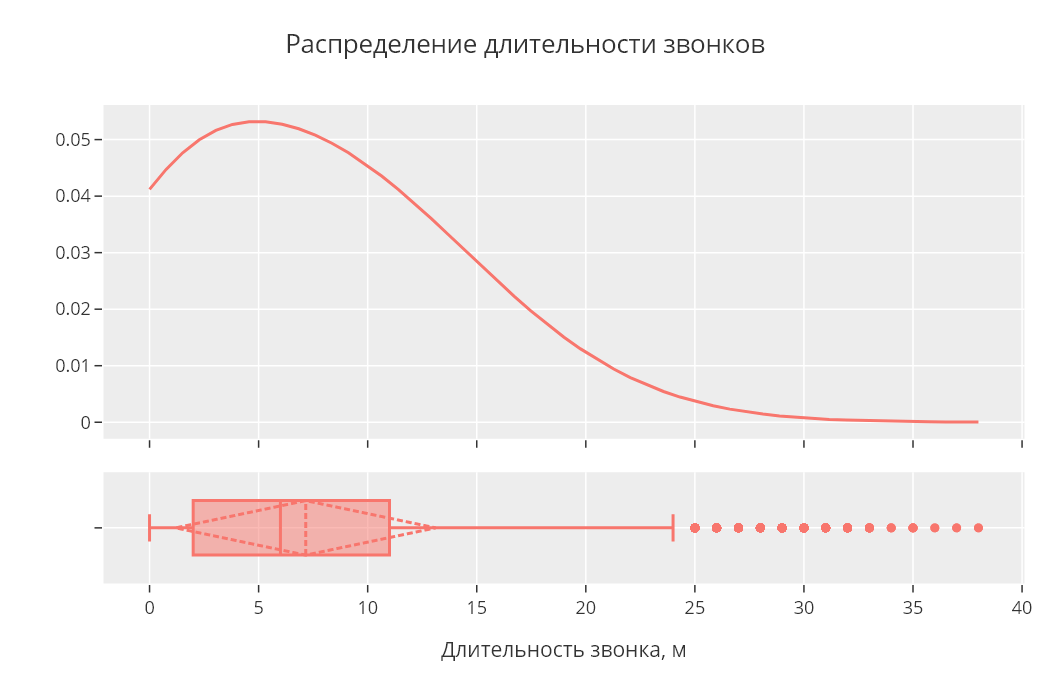

In [229]:
box_and_hist_plot(calls["duration"],"Распределение длительности звонков", "Длительность звонка, м", bw=0.7)

Наблюдаем резкий выброс около нулевого значения, необходимо принять меры по его устранению.

Заменим *нулевое* значение на *NaN*:

In [230]:
calls["duration"] = calls["duration"].replace(0, np.nan)

In [231]:
calls_group_user = calls.pivot_table(values="duration", index=["user_id", "id"], aggfunc="median", dropna=True)

Посмотрим на распределения продолжительности звонка у нескольких случайных пользователей:

Text(0.5, 1.0, 'Сравнение распределений длительностей звонков у случайных пользователей')

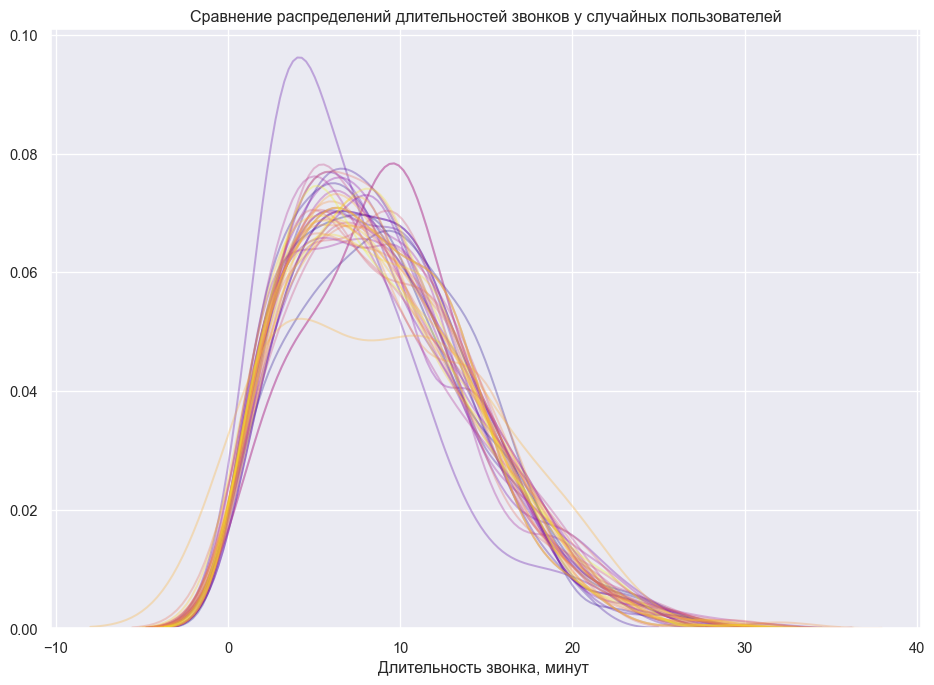

In [232]:
inx = calls_group_user.sample(40).index.get_level_values(0)
cm = mpl.cm.get_cmap('plasma', len(inx))

for col, i in enumerate(inx):
    sns.distplot(calls_group_user.loc[i], color=cm(col), hist=False, kde_kws=dict(alpha=0.3))
plt.xlabel("Длительность звонка, минут ")
plt.title("Сравнение распределений длительностей звонков у случайных пользователей")

Видим, что распределения без сильных выбросов, некоторые имеют несколько экстремумов, но в целом, линии гладкие, без резких изломов.   
Поэтому, будем осуществлять обработку *нулевой* продолжительности звонка следующим образом:  
* сгруппируем данные по каждом пользователю;
* найдем среднюю продолжительность звонка у каждого;
* заполним *нулевое* значение длительности звонка каждого пользователя соответствующим средним значением.

In [233]:
calls_group_user_mean = calls_group_user.pivot_table(values="duration", index="user_id")

In [234]:
def duration_fill_na(row):
    try:
        return calls_group_user_mean.loc[row["user_id"]]["duration"]
    except KeyError:
        return np.nan

In [235]:
calls_fill_nan = calls[calls["duration"].isna()].apply(duration_fill_na, axis=1)
calls_fill_nan.head(10)

0    8.75768
1    8.75768
5    8.75768
6    8.75768
9    8.75768
36   8.75768
38   8.75768
39   8.75768
40   8.75768
47   8.75768
dtype: float64

In [236]:
calls["duration"] = calls["duration"].fillna(calls_fill_nan)

In [237]:
calls["duration"] = np.ceil(calls["duration"]).astype("int64")

In [238]:
calls["duration"].isna().sum()

0

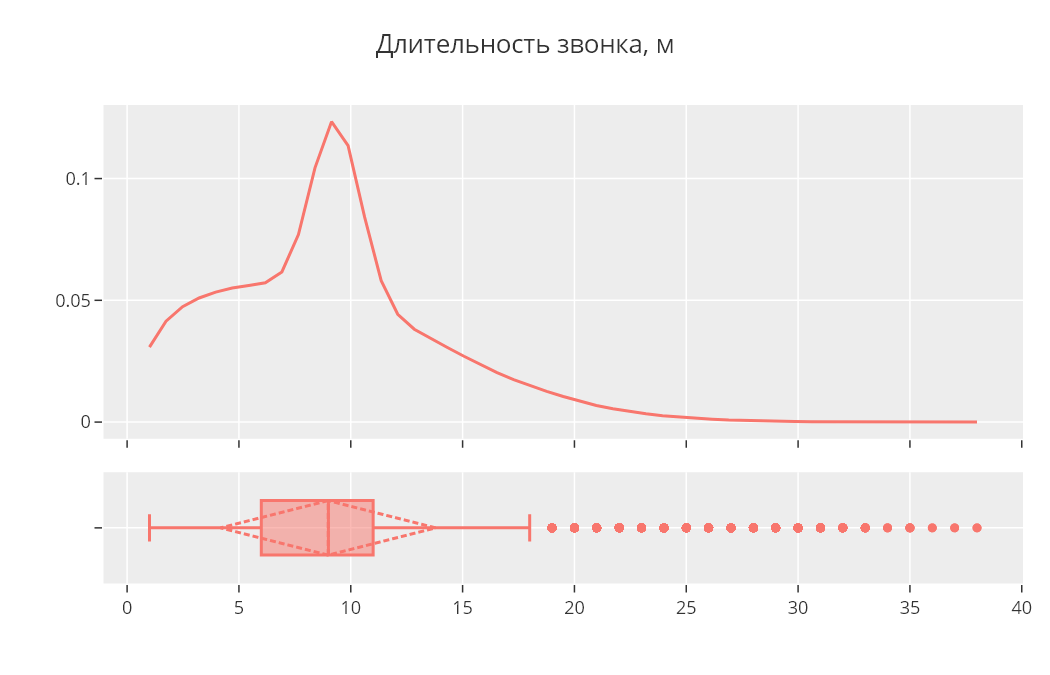

In [239]:
box_and_hist_plot(calls["duration"], "Длительность звонка, м", bw=0.2)

Получили новый пик, однако, он объясним, и подкреплен статистически. Если взглянуть на распределение средних значений длительности звонков по каждому абоненту, то получим, что действительно, значения около *9* встречаются часто.

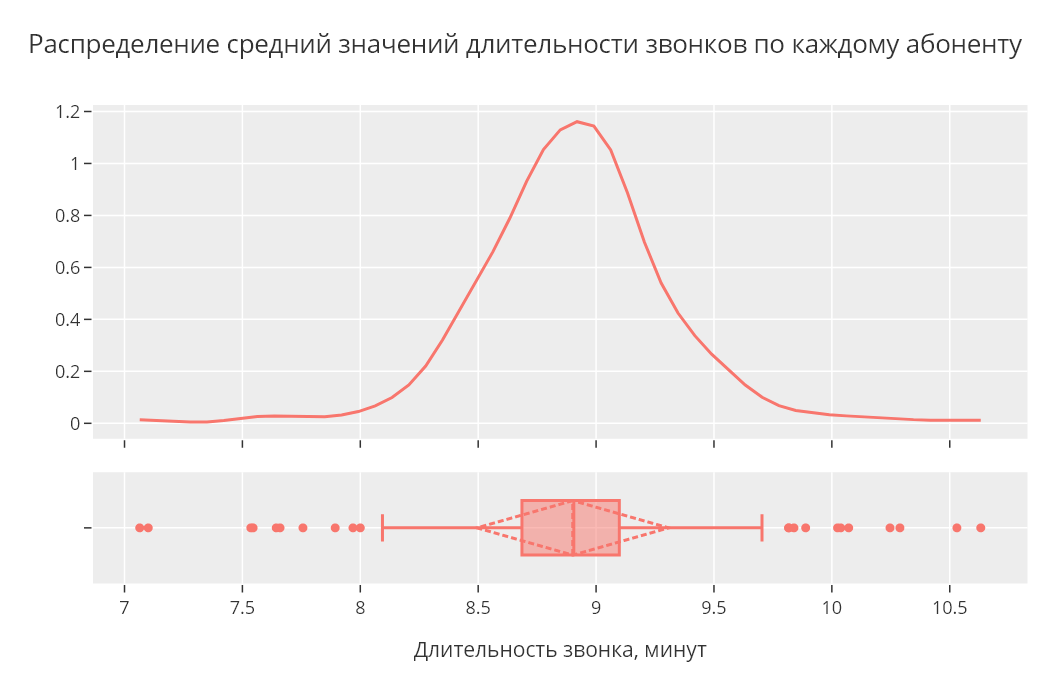

In [240]:
box_and_hist_plot(calls_group_user_mean["duration"], "Распределение средний значений длительности звонков по каждому абоненту", "Длительность звонка, минут")

In [241]:
# Q1, Q3 = calls["duration"].quantile([0.25, 0.75])
# IQR = Q3-Q1
# Goodcalls = calls.query("@Q1-1.5*@IQR <= duration <= @Q3+1.5*@IQR")

Предобработка данных о звонках(**calls**) завершена. 

<a id ="message_preparation"></a>
### message (Сообщения):

Осмотрим данные:

In [242]:
message.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [243]:
message.sample(10)

,id,message_date,user_id
102100,1416_417,2018-11-28,1416
61728,1271_313,2018-11-10,1271
107612,1433_219,2018-02-24,1433
66789,1284_377,2018-04-14,1284
83531,1347_148,2018-12-28,1347
20864,1089_867,2018-11-17,1089
64283,1277_960,2018-09-03,1277
6140,1026_74,2018-10-24,1026
92003,1380_164,2018-07-28,1380
90180,1374_628,2018-05-25,1374


Пропусков нет, однако необходимо выполнить преобразование типов данных.

Преобразуем *message_date* к типу данных времени:

In [244]:
message["message_date"] = pd.to_datetime(message["message_date"])

Добавим информацию, о том, в каком месяце было отправлено сообщение:

In [245]:
message = message.assign(message_period=message["message_date"].apply(lambda x: x.to_period('M')))

С колонкой **id** выполним аналогичные действия, которые сделали ранее с данными о звонках (calls):

In [246]:
message["id"] = message.apply(id_transform, axis=1)
message["id"].isna().sum()

0

C данными в колонке **id** всё хорошо!

In [247]:
message.sample(5)

,id,message_date,user_id,message_period
35758,147,2018-01-22,1155,2018-01
31124,158,2018-07-28,1135,2018-07
118487,49,2018-08-10,1482,2018-08
79827,183,2018-12-26,1333,2018-12
83165,76,2018-12-09,1346,2018-12


Предобработка данных о сообщениях завершена.

<a id ="internet_preparation"></a>
### internet (Данные об интернет-сессиях):

Осмотрим данные:

In [248]:
internet.sample(10)

,id,mb_used,session_date,user_id
65881,1225_2,64.56,2018-11-04,1225
9648,1033_28,226.1,2018-10-02,1033
91981,1311_91,196.92,2018-11-05,1311
109959,1374_170,343.98,2018-06-03,1374
7099,1024_154,95.33,2018-12-10,1024
32682,1114_79,145.13,2018-10-21,1114
132247,1439_364,234.68,2018-09-11,1439
98017,1330_225,779.01,2018-05-19,1330
44122,1152_340,182.47,2018-02-19,1152
24736,1085_105,174.37,2018-09-26,1085


In [249]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Пропусков нет, выполним преобразование типов:

Приведём колонку **session_date** к временному типу данных:

In [250]:
internet["session_date"] = pd.to_datetime(internet["session_date"])

Добавим информацию, о том, в каком месяце была открыта интернет-сессия:

In [251]:
internet = internet.assign(session_period=internet["session_date"].apply(lambda x: x.to_period('M')))

Преобразуем **id**:

In [252]:
internet["id"] = internet.apply(id_transform, axis=1)

In [253]:
internet["id"].isna().sum()

0

С **id** всё хорошо.

Округлим объем потраченного трафика за сессию в вверх(как сказано в условиях):

In [254]:
internet["mb_used"] = np.ceil(internet["mb_used"]).astype("int64")

In [255]:
internet.describe()

,id,mb_used,user_id
count,149 396,149 396,149 396
mean,205.812,370.622,1 252.1
std,157.267,278.387,144.051
min,0,0,1 000
25%,78,139,1 130
50%,172,349,1 251
75%,302,560,1 380
max,833,1 725,1 499


Обработка нулевых значений в **mb_used**:

In [256]:
print(f"{(internet['mb_used']<1).sum()/internet.shape[0]:.2%}")

13.12%


In [257]:
internet.query("mb_used == 0")

,id,mb_used,session_date,user_id,session_period
11,11,0,2018-08-28,1000,2018-08
38,38,0,2018-11-27,1000,2018-11
46,46,0,2018-06-30,1000,2018-06
67,67,0,2018-06-16,1000,2018-06
72,72,0,2018-06-15,1000,2018-06
...,...,...,...,...,...
149380,141,0,2018-12-11,1499,2018-12
149381,142,0,2018-11-01,1499,2018-11
149383,144,0,2018-11-27,1499,2018-11
149386,147,0,2018-10-21,1499,2018-10


Данных значений достаточно много, необходимо их обработать.

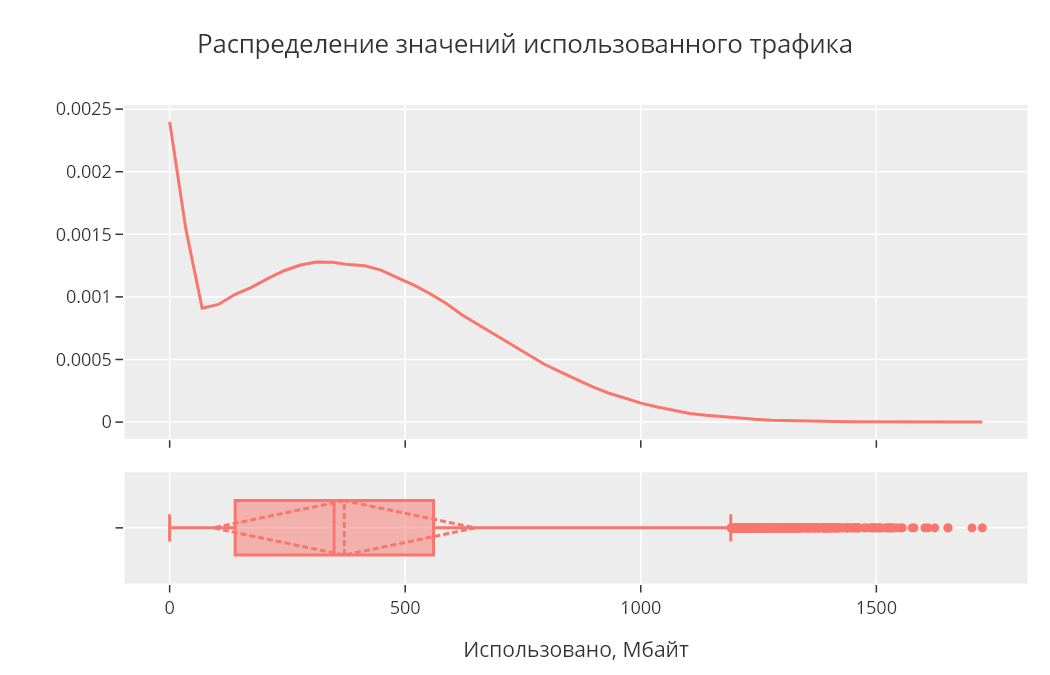

In [258]:
box_and_hist_plot(internet["mb_used"], "Распределение значений использованного трафика", "Использовано, Мбайт")

Видим похожую картину, как и в данных о звонках, однако, причины появления данных значений здесь может быть другая.  
Жаль, что нет информации о длительности сессии.  
Логика может быть следующая. Интернет-сессию может открыть фоновое приложение с мизерным потребляемым трафиком, но, на стороне оператора трафик считают дискретно, например, по 10 или 100 Кбайт, и трафик приложения, открывшего сессию, был меньше этого шага. И получается, что оператор фиксирует открытия сессии, но израсходованный трафик равен *нулю*.  
Также возможны и технические сбои при подсчете трафика.

Исходя из вышесказанного, будем обрабатывать *нулевое* значение трафика следующим образом: поскольку оператор использует округление вверх, то каждая интернет-сессиия будет иметь минимальный расход трафика с 1 Мбайт. Поэтому, заменим все *нулевые* значения на *1Мбайт*.

Не использовали стратегию устранения *нулевых* значений, как мы делали со звонками, по следующим причинам:
* различается сама *природа* данных явлений, за длительность звонков отвечает человек, т.е. они связаны только с человеческим фактором (не берем во внимание технические звонки, например, от сигнализаций), а на интернет-сессии влияют как пользователь, например, человек зашел проверить новостную ленту, так и приложения, например, фоновое обновления данных о погоде;
* некоторые телефоны могут прерывать открытую сессию, когда их блокируют, т.е. получаем дополнительное дробление, что отсутствует в звонках.

Преобработка данных об интернет-сессиях завершена.

<a id ="tariffs_preparation"></a>
### tariffs (Тарифы):

Осмотрим данные:

In [259]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [260]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


С данными всё хорошо.

In [261]:
tariffs = tariffs.set_index("tariff_name")

<a id="3_2.2"></a>
## 2.2. Расчет дополнительных метрик для каждого пользователя

### Количество сделанных звонков

In [262]:
number_calls = calls.pivot_table(values="duration", index="user_id", columns="call_period", aggfunc="count") 
number_calls = number_calls.rename_axis("Пользователь", axis=0, inplace=False).rename_axis("Месяц", axis=1, inplace=False)
number_calls.fillna(0)

Месяц,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
Пользователь,,,,,,,,,,,,
1000,0,0,0,0,22,43,47,52,58,57,43,46
1001,0,0,0,0,0,0,0,0,0,0,59,63
1002,0,0,0,0,0,15,26,42,36,33,32,33
1003,0,0,0,0,0,0,0,55,134,108,115,108
1004,0,0,0,0,9,31,22,19,26,29,19,21
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,17,112,152,129,155
1496,7,77,79,67,63,74,73,88,68,72,80,80
1497,0,0,0,0,0,0,0,0,0,66,64,71


Как видим информация о звонках есть не для каждого пользователя.

### Количество израсходованных минут:

In [263]:
spent_of_minute = calls.pivot_table(values="duration", index="user_id", columns="call_period", aggfunc="sum")
spent_of_minute = spent_of_minute.rename_axis("Пользователь", axis=0, inplace=False).rename_axis("Месяц", axis=1, inplace=False)
spent_of_minute.fillna(0)

Месяц,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
Пользователь,,,,,,,,,,,,
1000,0,0,0,0,204,307,394,498,574,467,392,405
1001,0,0,0,0,0,0,0,0,0,0,570,574
1002,0,0,0,0,0,126,259,334,305,293,306,290
1003,0,0,0,0,0,0,0,488,1 222,954,1 004,982
1004,0,0,0,0,51,219,151,145,181,209,149,178
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,128,966,1 264,1 107,1 346
1496,57,702,665,656,601,708,672,761,576,594,788,653
1497,0,0,0,0,0,0,0,0,0,650,531,675


### Количество отправленных сообщений

In [264]:
number_message = message.pivot_table(values="id", index="user_id", columns="message_period", aggfunc="count")
number_message = number_message.rename_axis("Пользователь", axis=0, inplace=False).rename_axis("Месяц", axis=1, inplace=False)
number_message.fillna(0)

Месяц,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
Пользователь,,,,,,,,,,,,
1000,0,0,0,0,22,60,75,81,57,73,58,70
1002,0,0,0,0,0,4,11,13,4,10,16,12
1003,0,0,0,0,0,0,0,37,91,83,94,75
1004,0,0,0,0,95,134,181,151,146,165,158,162
1005,7,38,56,41,42,47,56,64,52,44,51,54
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,13,82,82,79,84
1496,9,45,46,49,40,35,42,41,29,35,46,51
1497,0,0,0,0,0,0,0,0,0,20,14,17


### Объем израсходованного интернет-трафика

In [265]:
spent_mbyte = internet.pivot_table(values="mb_used", index="user_id", columns="session_period", aggfunc="sum")
spent_mbyte = spent_mbyte.rename_axis("Пользователь", axis=0, inplace=False).rename_axis("Месяц", axis=1, inplace=False)
spent_mbyte.fillna(0)

Месяц,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
Пользователь,,,,,,,,,,,,
1000,0,0,0,0,2 256,23 257,14 016,14 070,14 581,14 717,14 768,9 827
1001,0,0,0,0,0,0,0,0,0,0,18 452,14 053
1002,0,0,0,0,0,10 871,17 601,20 347,16 712,13 905,18 610,18 137
1003,0,0,0,0,0,0,0,8 571,12 479,14 779,11 368,10 132
1004,0,0,0,0,13 415,17 619,22 243,28 607,15 125,18 494,15 631,18 038
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,2 616,33 105,29 393,38 972,23 450
1496,3 766,28 523,24 990,21 098,23 740,20 163,24 395,23 560,26 970,28 215,25 092,20 757
1497,0,0,0,0,0,0,0,0,0,11 512,14 174,19 940


### Помесячная выручка с каждого пользователя 

Функция для вычисления помесячной выручки для каждого пользователя, также учитывается дата регистрации и прекращения использования тарифа. Если в таблицах с данными о расходе минут, сообщений, гигабайтов есть пропуски, будем считать, что пользователь не пользовался данной возможностью тарифа, и заполним пропуски нулями:

In [266]:
def monthly_revenue(row):
    # Используемый тариф
    tariff = tariffs.loc[row["tariff"]]
    # Превышение лимита по минутам
    ExcessMinutes = (spent_of_minute.reindex([row.name]).loc[row.name] - tariff["minutes_included"]).clip(0).fillna(0)
    # Превышение лимита по количеству сообщений
    Excessmessages = (number_message.reindex([row.name]).loc[row.name] - tariff["messages_included"]).clip(0).fillna(0)
    # Превышение лимита по использования интернет-трафика
    ExcessGBytes =  np.ceil((spent_mbyte.reindex([row.name]).loc[row.name]  - tariff["mb_per_month_included"]) / 1024.0).clip(0).fillna(0)
    # Определяем месяцы использования тарифа
    MaskUsegtariff = ((row["first_month_of_payment"] <= spent_of_minute.reindex([row.name]).loc[row.name].index) & 
                        (spent_of_minute.reindex([row.name]).loc[row.name].index <= row["last_month_of_payment"]))

    # Рассчитываем общую выручку (вместо 0 ставим NaN, чтобы нули не учитывались при расчете стат. величин)
    revenue = ((tariff["rub_monthly_fee"] + ExcessMinutes * tariff["rub_per_minute"] + 
                Excessmessages * tariff["rub_per_message"] + 
                ExcessGBytes * tariff["rub_per_gb"]) * MaskUsegtariff).replace(0, np.nan)
    return revenue

In [267]:
revenue = users.apply(monthly_revenue, axis=1)
# Заполним пропуски нулями, чтоб глаз не резало)
revenue.fillna(0)

Месяц,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
user_id,,,,,,,,,,,,
1000,0,0,0,0,1 950,1 950,1 950,1 950,1 950,1 950,1 950,1 950
1001,0,0,0,0,0,0,0,0,0,0,1 560,772
1002,0,0,0,0,0,550,1 150,1 550,950,550,1 350,1 150
1003,0,0,0,0,0,0,0,1 950,1 950,1 950,1 950,1 950
1004,0,0,0,0,1 950,1 950,1 950,1 950,1 950,1 950,1 950,1 950
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,1 950,2 400,1 950,3 300,1 950
1496,550,3 756,3 045,2 218,2 653,2 174,2 866,3 133,3 178,3 432,3 414,2 212
1497,0,0,0,0,0,0,0,0,0,1 000,643,2 075


Выведем основные стат. параметры выручки:

In [268]:
(revenue
     .describe()
     .round()
     .set_axis(labels=["Количество", "Среднее", "Станд. откл.", "Мин.", "Q1" , "Q2 (Медиана)", "Q3", "Макс."], inplace=False))

Месяц,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12
Количество,43,82,114,167,208,248,292,342,375,417,450,478
Среднее,1 017,1 232,1 558,1 404,1 605,1 608,1 638,1 708,1 633,1 725,1 724,1 918
Станд. откл.,666,710,740,701,761,770,783,810,751,852,836,1 018
Мин.,550,550,550,550,550,550,550,550,550,550,550,550
Q1,550,550,764,576,950,950,980,1 080,950,1 010,1 146,1 218
Q2 (Медиана),550,1 022,1 918,1 445,1 750,1 950,1 804,1 950,1 938,1 950,1 950,1 950
Q3,1 782,1 950,1 950,1 950,1 950,1 950,1 950,1 950,1 950,1 959,1 955,2 273
Макс.,2 504,3 756,3 045,3 117,3 900,4 851,4 200,4 886,3 928,4 879,6 328,7 256


Построим графики типа *ящик с усами* для каждого месяца, с учетом используемого тарифа:

Text(0.5, 1.0, 'Распределения выручки по месяцам')

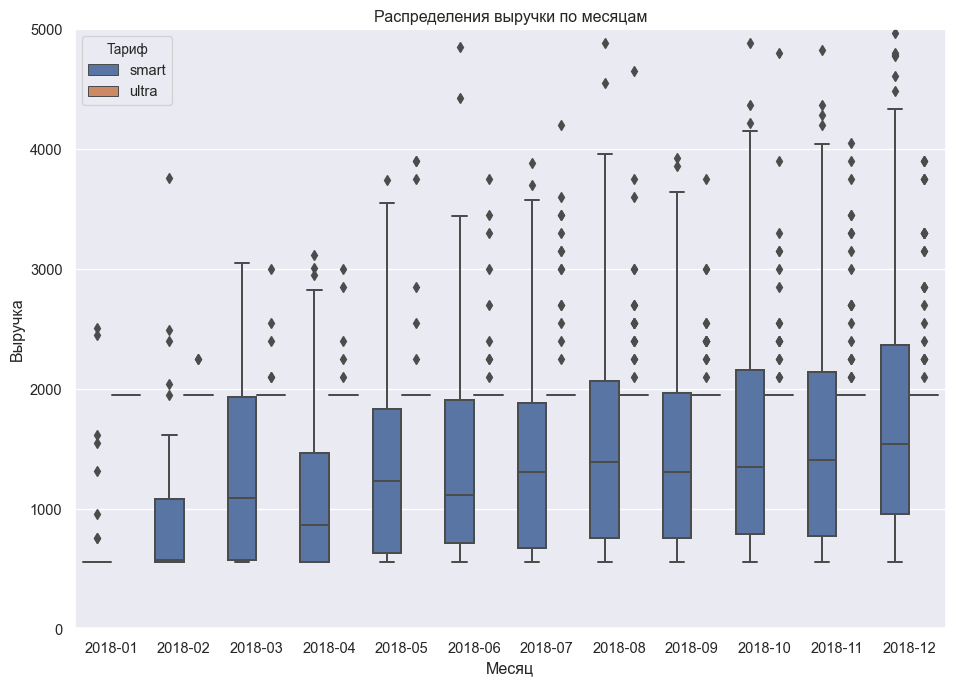

In [269]:
# Развернем данные
unstack_revenue = revenue.assign(tariff=users["tariff"]).melt(id_vars="tariff", var_name="month")

# Строим график
ax = sns.boxplot(data=unstack_revenue, x ="month", y="value", hue="tariff")

ax.set_ylim(0,5000)
ax.set_ylabel("Выручка")
ax.set_xlabel("Месяц")

ax.get_legend().set_title('Тариф')
ax.set_title('Распределения выручки по месяцам')

Из графика видно, что основной диапазон выручки с пользователя лежит в пределах от *550* до, примерно, *4000* рублей. 
___
Но, самое интересно, это то, что у тарифа *ultra* толком нет диапазона значений, очень мало пользователей платит больше, чем абонентская плата, отсюда и такой странный вид *коробок* данного тарифа на графике.  
А вот пользователи тарифа *smart* наоборот, к концу года всё чаще платили больше, чем абонентская плата.
___

<a id="3_3."></a>
# 3. Анализ данных

Вычислим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц, путем усреднения данных за каждый месяц использования тарифа каждым пользователем:

In [270]:
tariff_metric = users[["tariff"]].copy()

tariff_metric = tariff_metric.assign( minutes=np.ceil(spent_of_minute.reindex(tariff_metric.index).mean(axis=1)), 
                    message=np.ceil(number_message.reindex(tariff_metric.index).mean(axis=1)),
                    mbyte=np.ceil(spent_mbyte.reindex(tariff_metric.index).mean(axis=1)),
                    revenue=revenue.reindex(tariff_metric.index).mean(axis=1))
tariff_metric = (tariff_metric.reset_index()
                    .set_index(["tariff", "user_id"])
                    .sort_index())
tariff_metric

minutes  message  mbyte  revenue
tariff user_id                                  
smart  1001         572      nan 16 253    1 166
       1002         274       10 16 598 1 035.71
       1005         690       46  8 318 1 218.25
       1006         396      nan 14 945  942.455
       1007         633       25 14 644 1 300.33
...                 ...      ...    ...      ...
ultra  1476         635        6 16 715    1 950
       1485         782      155 23 447    1 950
       1491         636       48 17 957    1 950
       1493         471       47 27 234    2 850
       1495         963       68 25 508    2 310

[500 rows x 4 columns]

## Cреднее количество, дисперсия и стандартное отклонение для каждой величины:

In [271]:
mean_var_std = tariff_metric.reset_index().pivot_table(index="tariff", values=["minutes", "message", "mbyte", "revenue"], aggfunc=["mean", "var", "std"]).round()
(mean_var_std
     .rename(columns={"mean":"Среднее значение", "var":"Дисперcия", "std":"Станд. отклонение",
                    "minutes":"Минуты", "message":"Сообщения", "mbyte":"Мбайты", "revenue":"Выручка"})
     .rename_axis("Тариф", axis=0))

Среднее значение                            Дисперcия                    \
                Мбайты Сообщения Минуты Выручка      Мбайты Сообщения  Минуты   
Тариф                                                                           
smart           16 212        38    529   1 526 1.28278e+07       617  32 313   
ultra           19 745        65    685   2 086 6.68839e+07     1 880 111 079   

              Станд. отклонение                           
      Выручка            Мбайты Сообщения Минуты Выручка  
Тариф                                                     
smart 481 693             3 582        25    180     694  
ultra  90 024             8 178        43    333     300

Построим графики для каждого тарифа по следующим величинам: 
* Количество использованных минут разговора;
* Количество отправленных сообщений;
* Объем потраченного интернет-трафика.

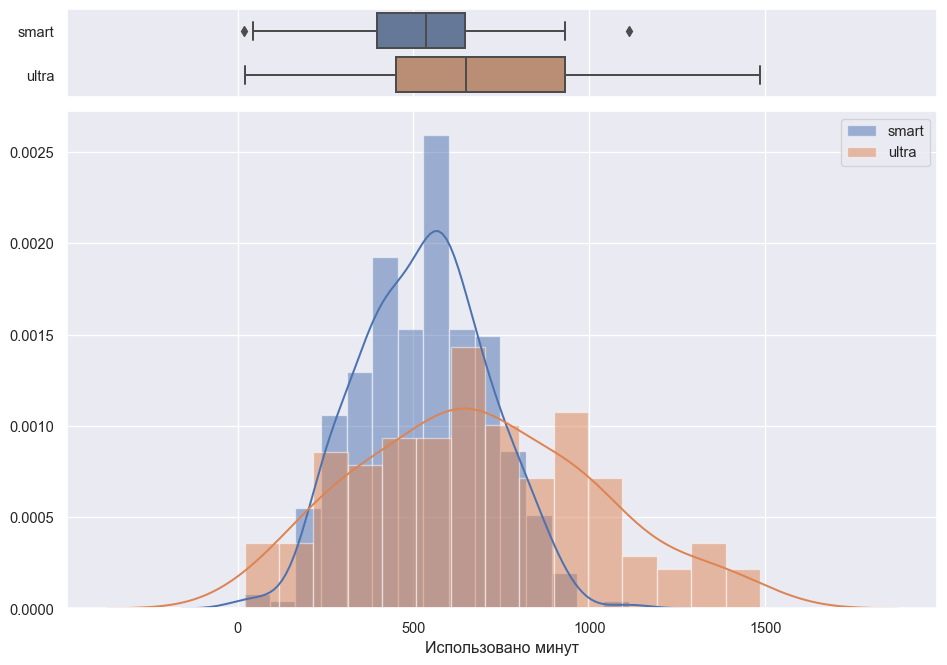

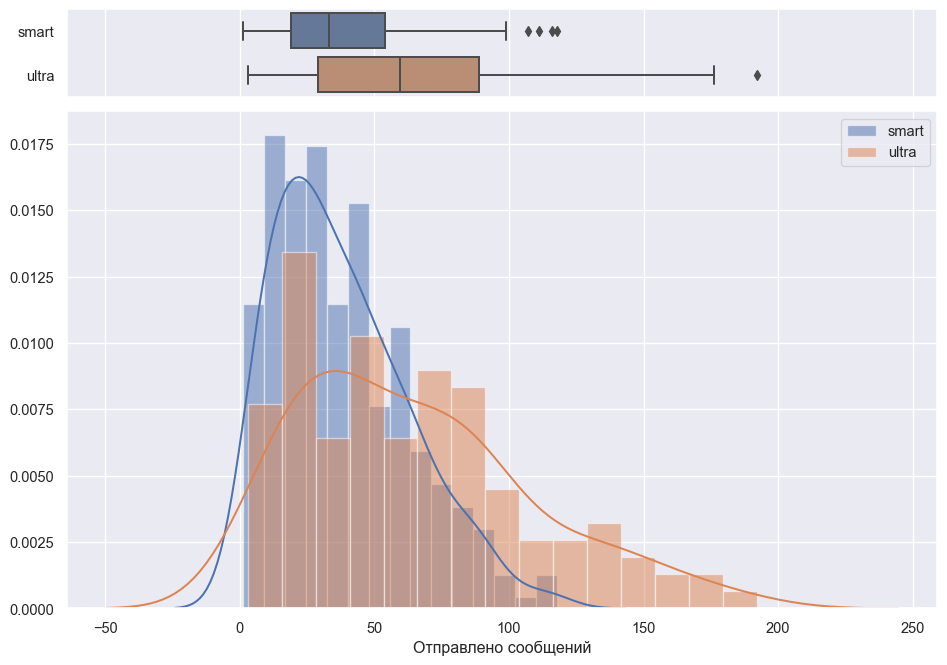

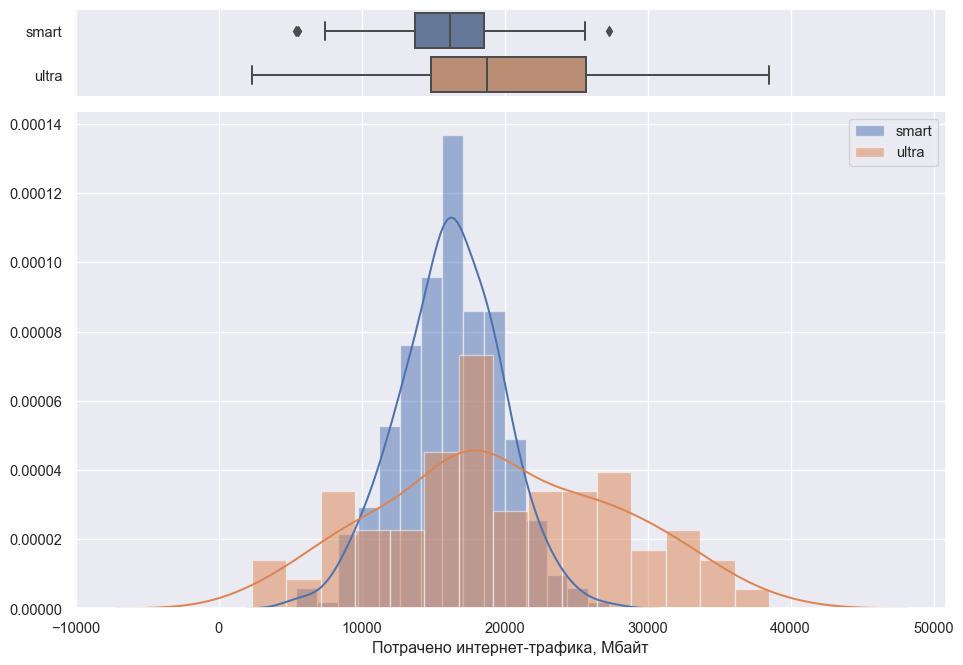

In [272]:
labels = ["Использовано минут", "Отправлено сообщений", "Потрачено интернет-трафика, Мбайт"]

for columns_name,  label in zip(tariff_metric.columns.drop("revenue"), labels):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85), "hspace":0.05})

    sns.distplot(tariff_metric.loc["smart", columns_name].dropna(), label="smart", hist_kws=dict(alpha=0.5), bins=15)
    sns.distplot(tariff_metric.loc["ultra", columns_name].dropna(), label="ultra", hist_kws=dict(alpha=0.5), bins=15)

    sns.boxplot(data= tariff_metric.reset_index().dropna(), y="tariff", x=columns_name, ax=ax_box,orient="h", saturation=0.5 )
    ax_box.set_xlabel("")
    ax_box.set_ylabel("")
    ax_hist.set_xlabel(label)

    ax_hist.legend()  

Распределения имеют колообразный вид, данный факт объясняется тем, что величины, представленные на графиках являются средними значениями за месяц по каждому пользователю. т.е. это распределения выборочных средний, а по центральной предельной теореме данное распределение стремится к нормальному.  
___
Стандартное отклонение тарифа *Ультра* по всем величинам, кроме *выручки*, имеет б$\acute{о}$льшее значение, чем у тарифа *Смарт*, данный факт говорит о том, что пользователи тарифа *Ультра* имееют более разнообразные потребности. 
___
Чтобы сказать еще что-нибудь о пользователях тарифов, необходимо провести дополнительный анализ, например, оценить насколько коррелированы величины потреблений услуг (минуты, сообщения, интернет-трафик) между собой, т.е. если пользователь использует много минут, будет ли он использовать и много сообщений, и интернет-трафика.   
Большое стандартное отклонение в тарифе *Ультра* объясняется, как мне кажется, тем, что пользователи данного тарифа потребляют услуги избирательно, например, тратят много минут, а сообщений и интернет-трафика мало, или наоборот.
___

Для *выручки* построим графики отдельно:

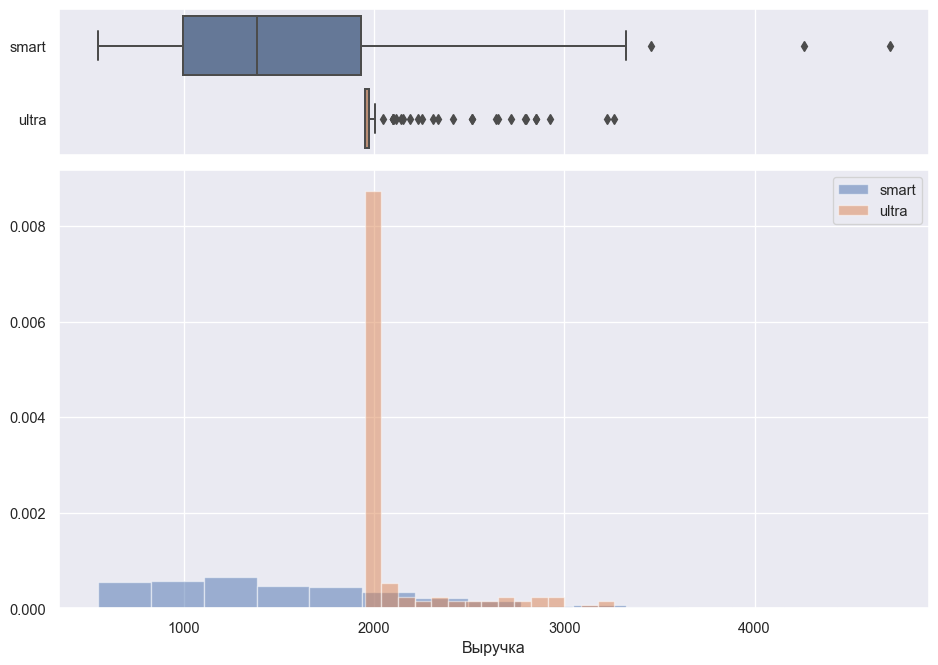

In [273]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75), "hspace":0.05})

sns.distplot(tariff_metric.loc["smart", 'revenue'].dropna(), label="smart", hist_kws=dict(alpha=0.5), bins=15, norm_hist=True, kde=False)
sns.distplot(tariff_metric.loc["ultra", 'revenue'].dropna(), label="ultra", hist_kws=dict(alpha=0.5), bins=15, norm_hist=True, kde=False)
sns.boxplot(data= tariff_metric.reset_index().dropna(), y="tariff", x="revenue", ax=ax_box,orient="h", saturation=0.5 )
ax_box.set_xlabel("")
ax_box.set_ylabel("")
ax_hist.set_xlabel("Выручка")
ax_hist.legend()  

Данные распределения не очень похожи на нормальные, у тарифа *Смарт* большая дисперсия, что колокол не наблюдается, а у тарифа *Ультра* есть сильно доминирующее значение, равное абонентской плате за тариф.
___
Вывод из графика можно сделать следующий, пользователи *Смарт'а* часто превышают лимиты, установленные тарифом, и вынуждены дополнительно платить за услуги оператору, а пользователи *Ультр'ы* наоборот, обычно укладываются в тариф. 

<a id="3_4."></a>
# 4. Проверка гипотез

<a id="3_4.1"></a>
##  4.1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

*  <h3>Нулевая гипотеза $H_0$</h3> 

Нулевая гипотеза формулируется используя знак равенство, поэтому для проверки поставленной гипотезы сформулируем $H_0$ следующим образом:  
___
<font color="green"> $H_0$ - Средняя выручка пользователей тарифов *Ультра* и *Смарт* равны.
___

* <h3>Альтернативная гипотеза $H_1$</h3>

___
<font color="green"> $H_1$ - Средняя выручка пользователей тарифов *Ультра* и *Смарт* ***не*** равны.
___

Поскольку нам неизвестна информация о генеральной совокупности (значение выручек для всех возможных пользователей за всё время), то анализ будем производить по *выборке* данных за 2018 год, и для *500* пользователей (id 1000-1500).   
Для проверки гипотез по выборке воспользуемся ***t-тестом***:

In [274]:
# Задаем пороговое значение
alpha = 0.05
# Проводим t-тест для средних из двух независимых выборок
results = st.ttest_ind(tariff_metric.loc["smart", 'revenue'], tariff_metric.loc["ultra", 'revenue'])

if alpha > results.pvalue:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть гипотезу")
print(f"p-value: {results.pvalue:.3f}")

Отвергаем нулевую гипотезу
p-value: 0.000


Отвергаем нулевую гипотезу, отсюда следует, что различия средних значений выручки пользователей каждого тарифа являются статистически значимыми.

<a id="3_4.2"></a>
## 4.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Подготовим данные: сгруппирую информацию о средней выручке каждого пользователя по городу, из Москвы пользователь или нет:

In [275]:
city_compare = tariff_metric.reset_index(0, drop=True)
city_compare = city_compare.assign(is_moscow=users.reindex(city_compare.index)["city"] == "москва")
city_compare = city_compare.pivot_table(index=["is_moscow", "user_id"])
city_compare

mbyte  message  minutes  revenue
is_moscow user_id                                  
False     1000    13 437       62      406    1 950
          1002    16 598       10      274 1 035.71
          1004    18 647      149      161    1 950
          1005     8 318       46      690 1 218.25
          1006    14 945      nan      396  942.455
...                  ...      ...      ...      ...
True      1453    23 512       58    1 077    1 950
          1461    17 219       50      654    1 950
          1476    16 715        6      635    1 950
          1481    16 876       19      352 1 163.64
          1490    16 973       47      381 1 087.33

[500 rows x 4 columns]

*  <h3>Нулевая гипотеза $H_0$</h3>

___
<font color="green"> $H_0$ - Средняя выручка пользователей из Москвы ***равна*** среднее выручки пользователей из других городов.
___

* <h3>Альтернативная гипотеза $H_1$</h3>

___
<font color="green"> $H_1$ - Средняя выручка пользователей из Москвы ***не равна*** среднее выручки пользователей из других городов.
___

Применим t-тест, как было сделано выше:

In [276]:
# Задаем пороговое значение
alpha = 0.05
# Проводим t-тест для средних из двух независимых выборок
results = st.ttest_ind(city_compare.loc[True, "revenue"], city_compare.loc[False, "revenue"])

if alpha > results.pvalue:
    print("Отвергаем гипотезу нулевую гипотезу")
else:
    print("Не можем отвергнуть гипотезу")
print(f"p-value: {results.pvalue:.3f}")

Не можем отвергнуть гипотезу
p-value: 0.290


По результатам теста мы не можем отвергнуть нулевую гипотезу. Отсюда, мы не подтверждаем и не отвергаем гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других городов, не достаточно информации для этого.

Постороим диаграммы размаха величин выручек пользователей из Москвы и других городов:

Text(0.5, 1.0, 'Диаграммы размаха')

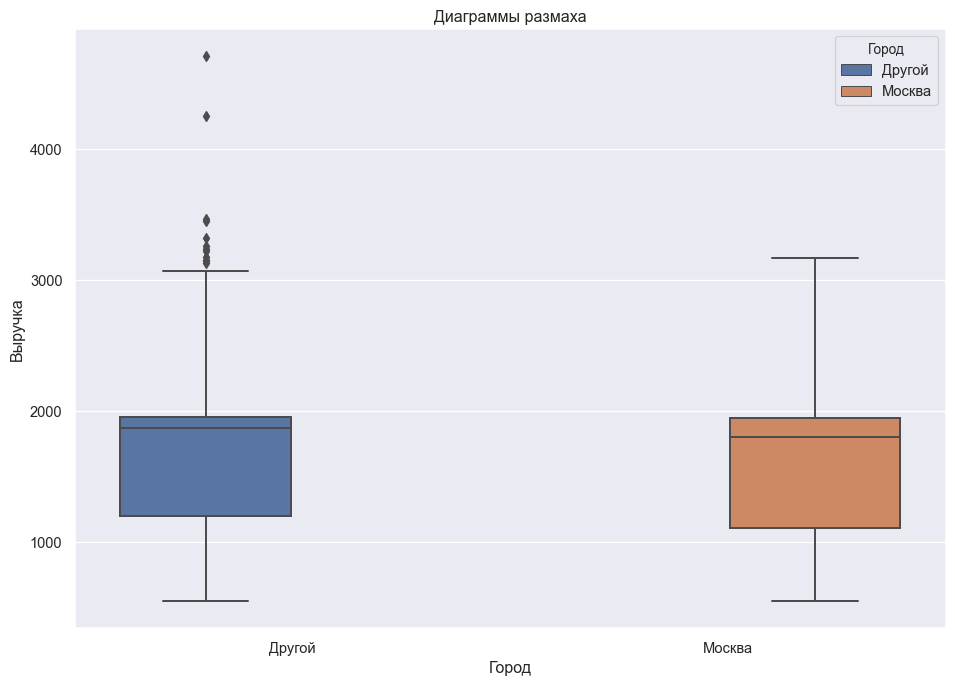

In [277]:
unstack_city_compare = city_compare.reset_index().melt(id_vars="is_moscow", value_vars="revenue")
unstack_city_compare["is_moscow"] = unstack_city_compare["is_moscow"].replace([0,1], ["Другой", "Москва"])

ax = sns.boxplot(data=unstack_city_compare, x="is_moscow",y="value", hue="is_moscow")
ax.set_xticklabels(["Другой", "Москва"])
ax.set_xlabel("Город")
ax.set_ylabel("Выручка")
ax.get_legend().set_title("Город")
ax.set_title("Диаграммы размаха")

Как видно из графика, доверительные интервалы обеих выборок пересекаются, что дополнительно подтверждает, что нельзя отвергать нулевую гипотезу.

## Вывод

В данном шаге:
* Подтвердили, что средние выручки пользователей тарифов *Смарт* и *Ультра* различаются;
* Пришли к тому, что выручки пользователей из Москвы и других городов не имеют статистически значимых различий. 

<a id="3_5."></a>
# 5. Общий вывод

Задание на проект было следующее: выбрать, какой тариф лучше?   
Попытаемся ответить сейчас на данный вопрос.  
___
*Со стороны пользователя* 

Для пользователя лучше, когда он удовлетворяет свои потребности в услугах связи за меньшую цену. Поэтому критерием подбора лучшего тарифа является плата за него, с учетом того, что он удовлетворяет необходимым требованиям.   
Итак, у каждого тарифа есть установленные лимиты, за превышение которых необходимо будет доплачивать, причем размер доплат нельзя назвать низкими, поэтому пользователю желательно подбирать такой тариф, за лимиты которого он не будет выходить.  
Например, если потребления услуг тарифа у пользователя невелико, то ему лучше выбрать *Смарт*, если велико, то *Ультра*. Однако, если пользователь превышает какой-либо лимит у тарифа *Смарт*, но незначительно, так что общаяя плата не превышает абонентскую плату тарифа *Ультра*, то нет смысла переходить на более дорогой вариант.

___
*Со стороны оператора* 

Для оператора важен размер выручки с каждого пользователя, оценим данную величину:


In [278]:
(tariff_metric
     .pivot_table(values="revenue", index="tariff", aggfunc=lambda x: x.sum()/x.count())
     .round()
     .set_axis(["Выручка"], axis=1, inplace=False)
     .rename_axis(["Тариф"], axis=0, inplace=False))

,Выручка
Тариф,
smart,1 526
ultra,2 086


Проверим также и с помощью t-теста:

In [281]:
# H0 - средние равны
# H1 - у Смарт среднее ниже, чем у Ультра
# Задаем пороговое значение
alpha = 0.05
# Проводим t-тест для средних из двух независимых выборок
results = st.ttest_ind(tariff_metric.loc["smart", 'revenue'], tariff_metric.loc["ultra", 'revenue'])

if (alpha > results.pvalue/2) and (tariff_metric.loc["smart", 'revenue'].mean() < tariff_metric.loc["ultra", 'revenue'].mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть гипотезу")
print(f"p-value: {results.pvalue:.3f}")

Отвергаем нулевую гипотезу
p-value: 0.000


Нулевую гипотезу отвергнули, поэтому можно предположить, что у тарифа *Смарт* средняя выручка пользователя ниже, чем у тарифа *Ультра*

Отсюда можно сделать вывод, что тариф *Ультра* выгоднее для оператора, однако, проведем еще один анализ:

In [282]:
group_tariff = tariff_metric.groupby("tariff").sum()
((group_tariff*100 / group_tariff.sum()).round()
    .set_axis(["Минуты", "Сообщения", "Интернет-трафик", "Выручка"], axis=1, inplace=False)
    .rename_axis("Тариф", axis=0))

,Минуты,Сообщения,Интернет-трафик,Выручка
Тариф,,,,
smart,65,59,66,63
ultra,35,41,34,37


А здесь мы видим, что если оценивать не одну выручка, а еще учитывать размер предоставленных услуг, то получаем, что тарифы, примерно, равны.   
По тарифу *Смарт* было предоставлено около *66%* из всех услуг, и размер выручки составил *63%*, также и с тарифом *Ультра*. 

Но, охват у тарифа *Смарт* выше, 70.2% против 29.8% у тарифа *Ультра*:

In [283]:
users["tariff"].value_counts(normalize=True) * 100

smart    70.2
ultra    29.8
Name: tariff, dtype: float64

Общий вывод можно сделать следующий: для оператора важны оба тарифа, один (*Смарт*) дает большую часть выручки, и широкий охват пользователей, а второй (*Ультра*) удовлетворяет потребность более требовательных пользователей, однако их не так мало, почти треть от общего количества, поэтому данный тариф также стоит поддержить и продвигать, как и *Смарт*.